In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from scipy.fft import fft, fftfreq

current_path = os.path.abspath('.')

In [56]:
# Function for parsing and structuring data.
# test = True means the data file has an extra column containing an activity label.
def structure_file(df, test=False):
    if not test:
        df = df[0].str.split('\t', n=4, expand=True)
        df.columns = ["time", "sensor", "x", "y", "z"]
    else:
        df = df[0].str.split('\t', n=5, expand=True)
        df.columns = ["time", "sensor", "x", "y", "z", "labels"]
    
    # We only consider accelerometer and gyroscope data
    GYR_data = df.loc[df['sensor'] == 'GYR']
    ACC_data = df.loc[df['sensor'] == 'ACC']

    GYR_data.index = GYR_data['time'].apply(pd.to_numeric)
    ACC_data.index = ACC_data['time'].apply(pd.to_numeric)
    GYR_data = GYR_data.drop('sensor', axis=1)
    ACC_data = ACC_data.drop('sensor', axis=1)
    if not test:
        GYR_data.columns = ['time_gyr', "gyr_x", "gyr_y", "gyr_z"]
        ACC_data.columns = ['time_acc', "acc_x", "acc_y", "acc_z"]
    else:
        GYR_data.columns = ['time_gyr', "gyr_x", "gyr_y", "gyr_z", "label"]
        ACC_data.columns = ['time_acc', "acc_x", "acc_y", "acc_z", "drop_label"]
        ACC_data = ACC_data.drop("drop_label", axis=1)
        
    # We combine accelerometer and gyroscope data that has close but not necessarily identical timestamps
    min_idx = np.argmin([ACC_data.shape[0], GYR_data.shape[0]]) 
    max_idx = np.argmax([ACC_data.shape[0], GYR_data.shape[0]])  
    data_acc_gyr = [ACC_data, GYR_data] 
    data_acc_gyr[max_idx] = data_acc_gyr[max_idx].reindex(data_acc_gyr[min_idx].index, method='nearest', tolerance=3)
    combined_data = pd.concat(data_acc_gyr, axis=1)
    restructured_data = combined_data.dropna().reset_index(drop=True)
    restructured_data = restructured_data.apply(pd.to_numeric)
    return restructured_data

# Function for computing moving average
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def moving_fft(x, sampling_rate, window_size=100):
    chunks = len(x) // window_size
    power = np.zeros_like(x)
    for ind, chunk in enumerate(range(chunks)):
        spectrum = fft(x[chunk*window_size:(chunk+1)*window_size])
        spectrum = spectrum[:len(spectrum)//2]
        freq_resolution = sampling_rate/len(spectrum)
        power_spectrum = np.abs(spectrum)**2
        total_power = np.sum(power_spectrum * freq_resolution)
        power[chunk*window_size : (chunk+1)*window_size] = total_power
        
    return power

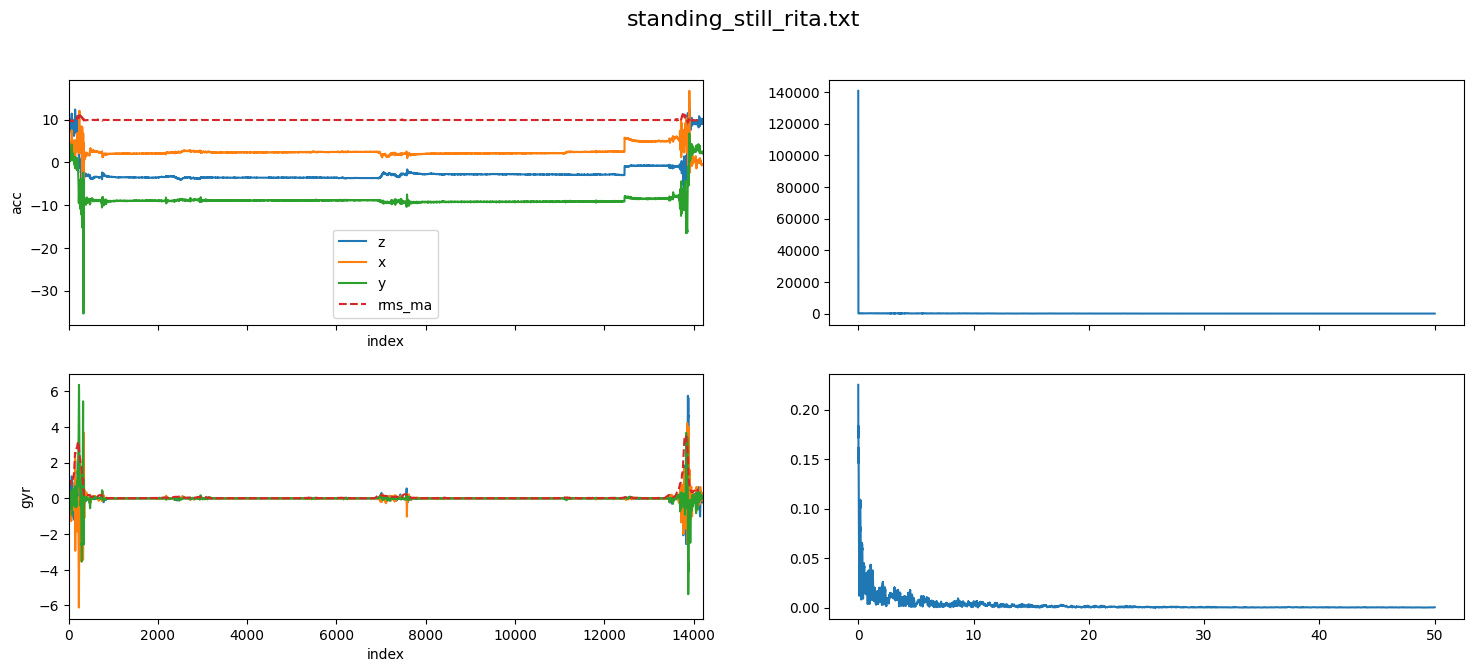

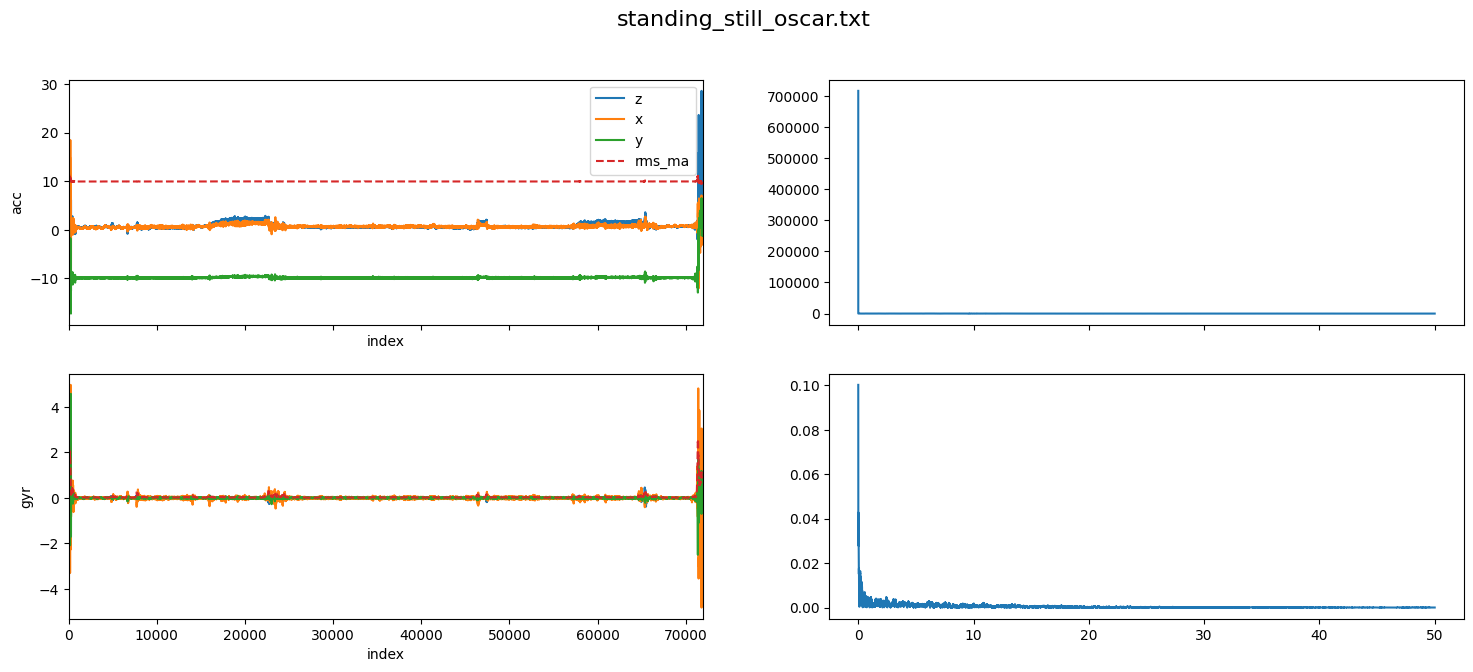

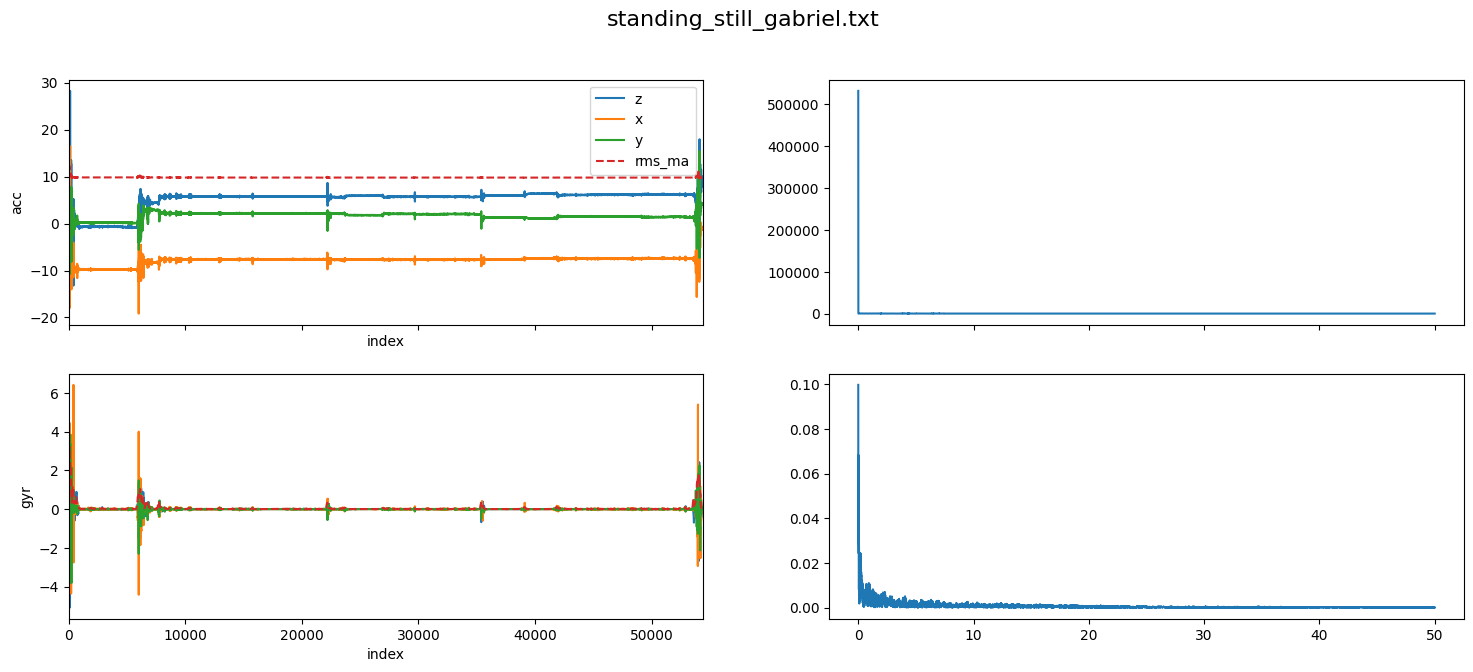

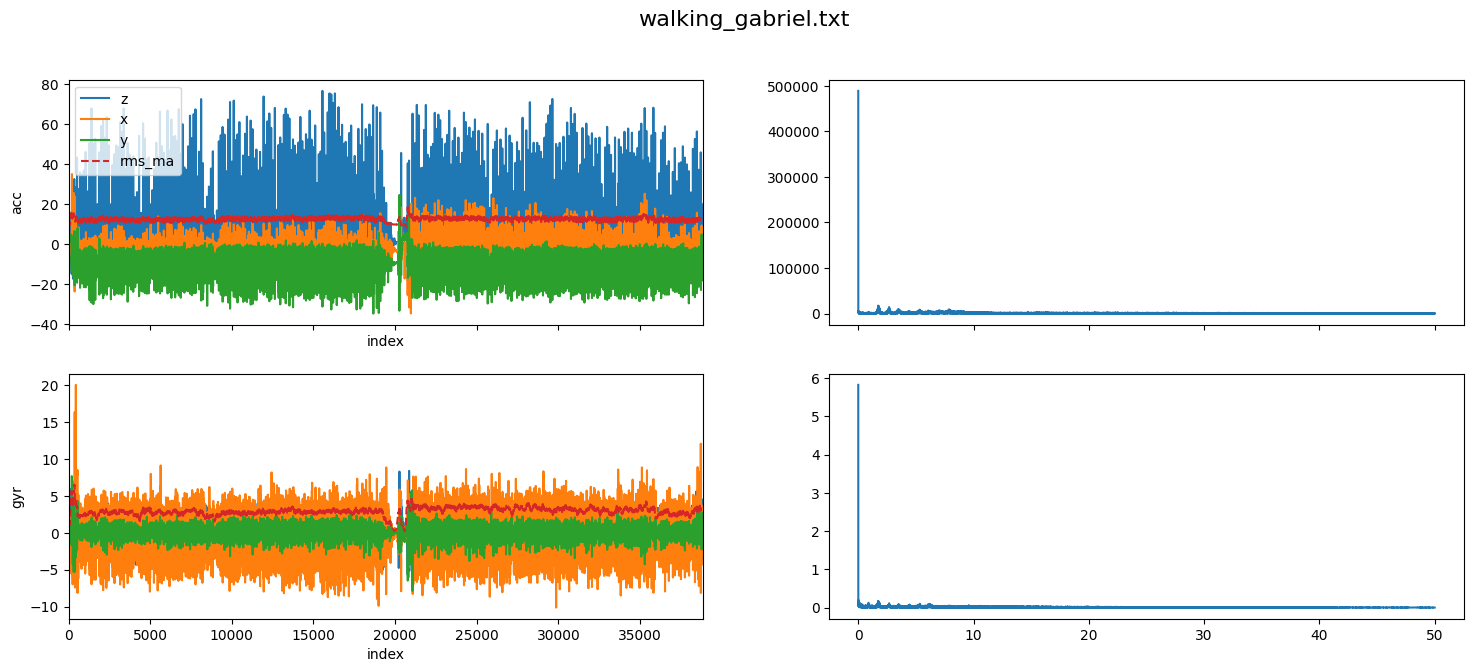

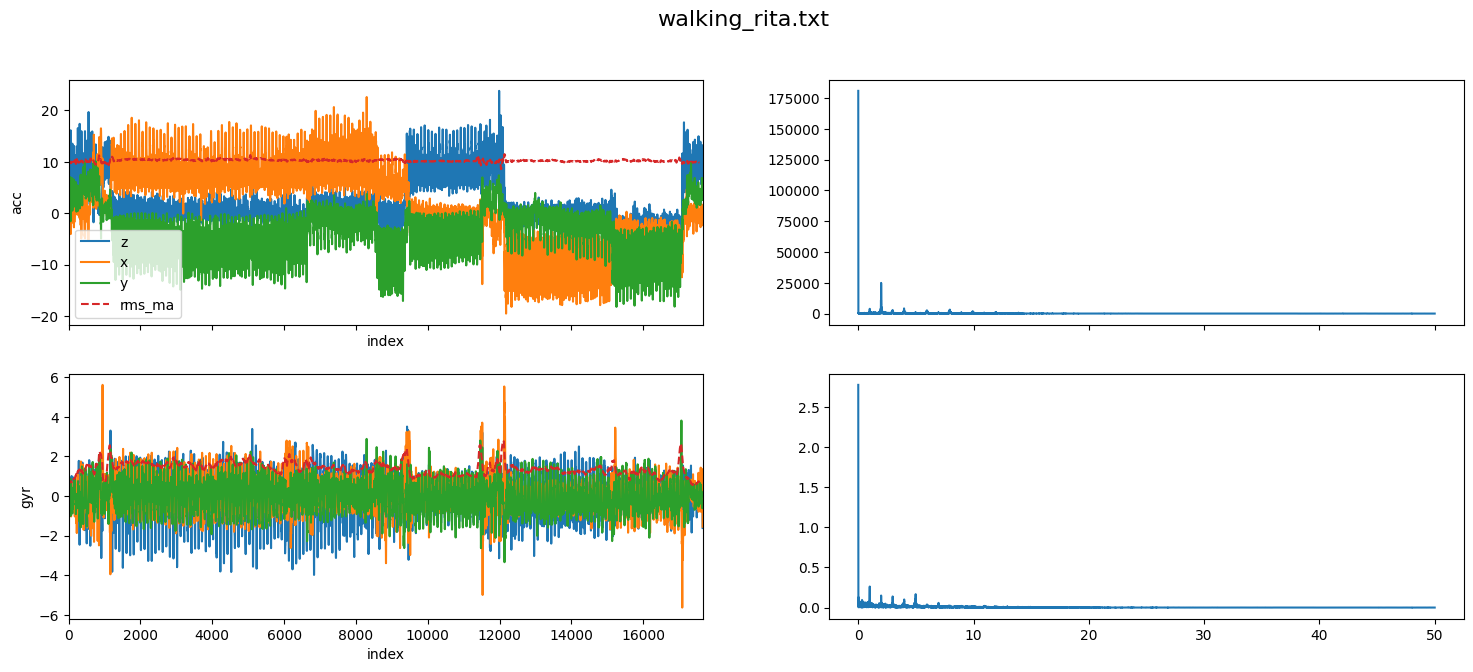

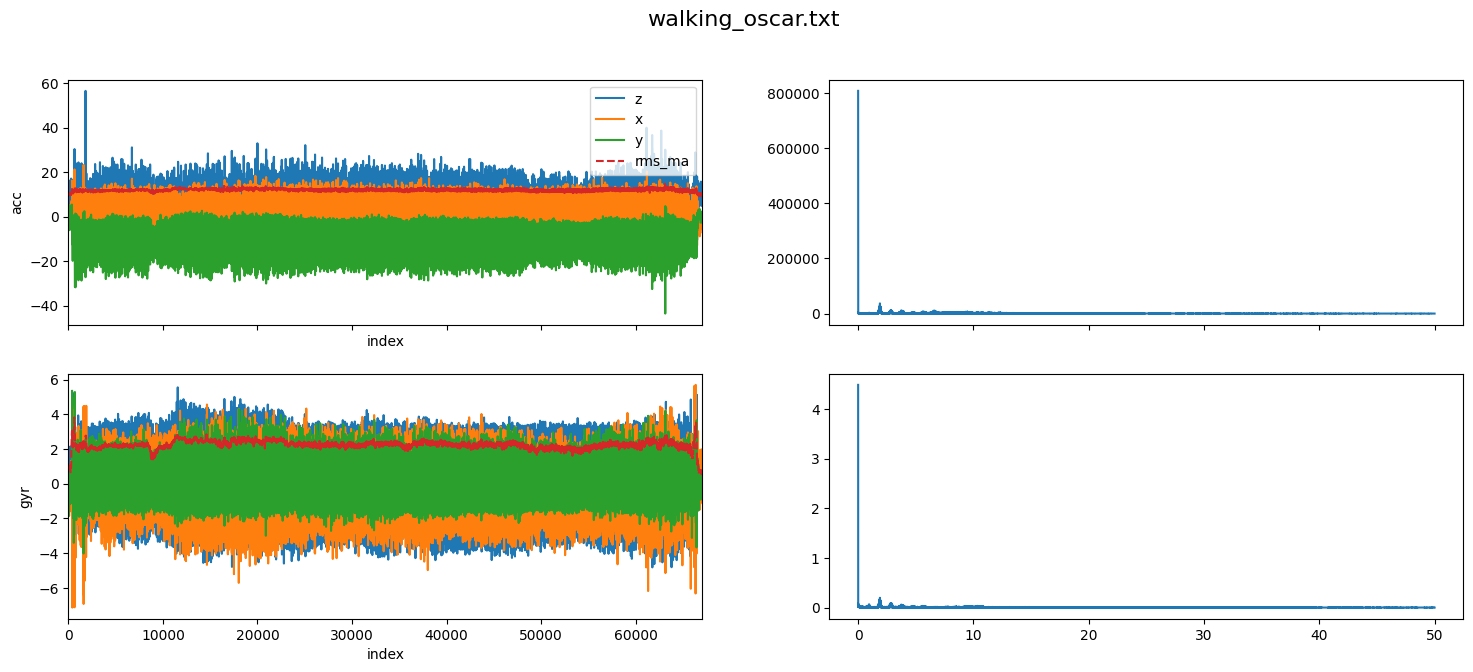

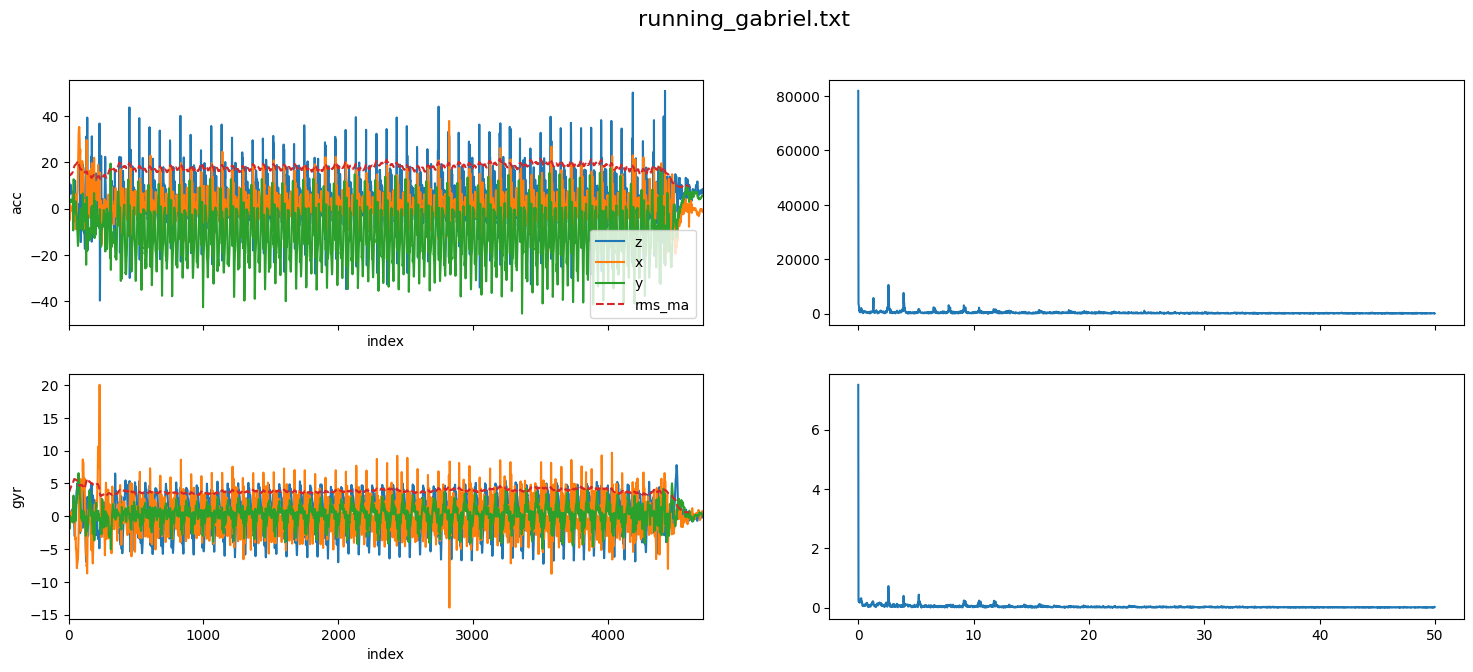

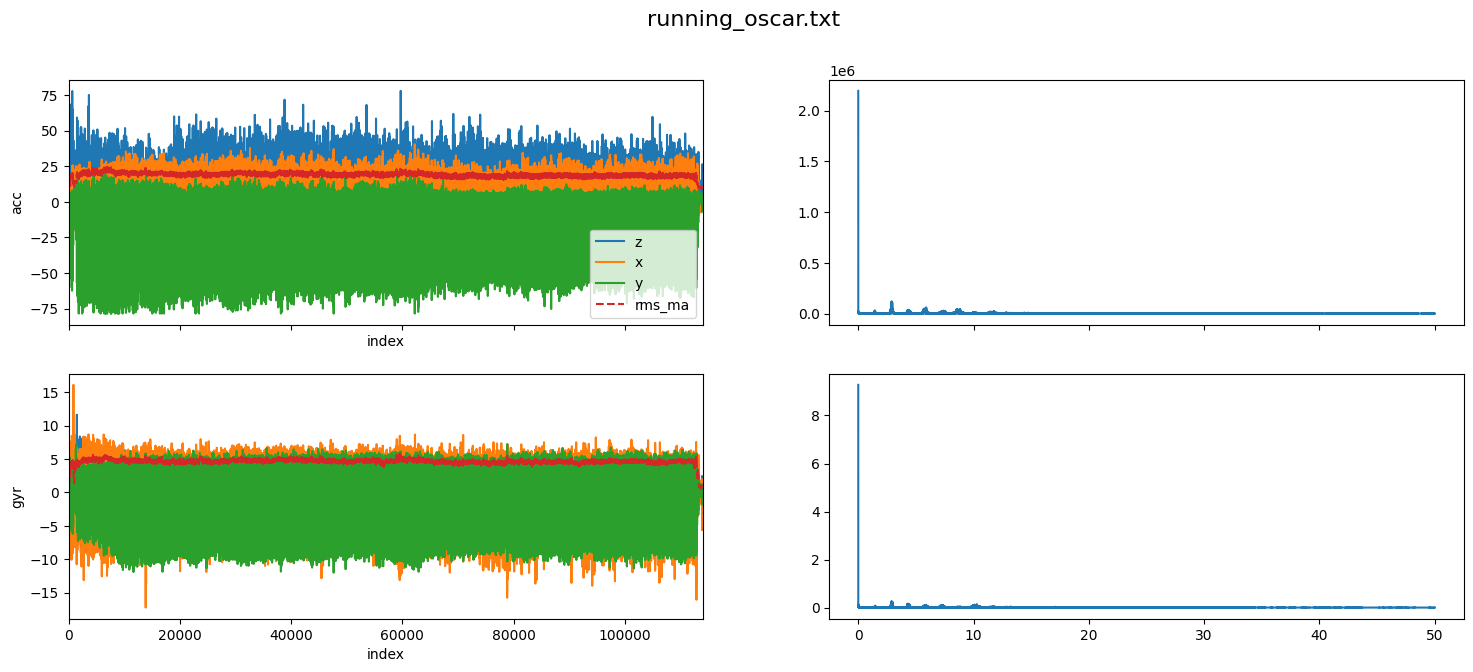

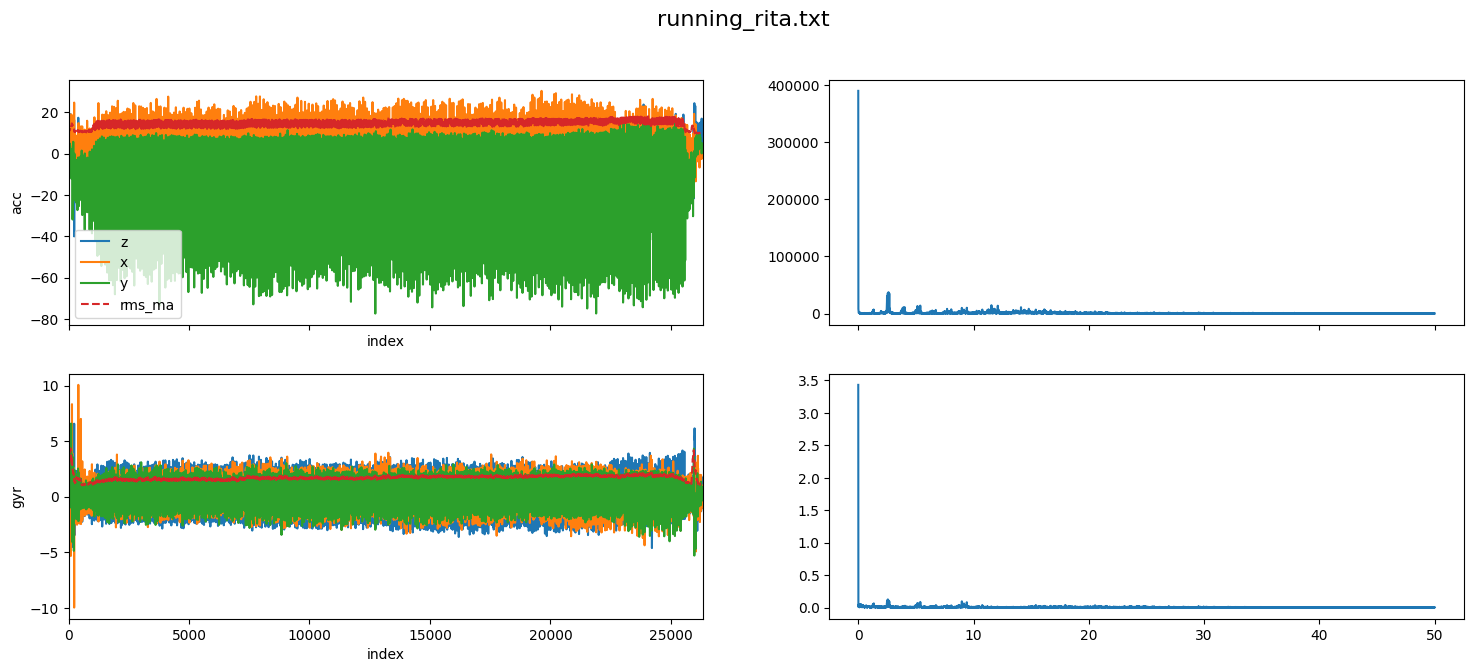

In [5]:
# Visualizing data to gain insight

data_types = ["standing_still", "walking", "running"]

for data_type in data_types:
    data_path = os.path.join(current_path, data_type)
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        data = pd.read_csv(file_path, header=None)
        pandas_data = structure_file(data)
        # pprint(pandas_data)

        # Compute rms
        rms_acc = np.sqrt(pandas_data['acc_x']**2 + pandas_data['acc_y']**2 + pandas_data['acc_z']**2).to_numpy(dtype=float, copy=True)
        rms_gyr = np.sqrt(pandas_data['gyr_x']**2 + pandas_data['gyr_y']**2 + pandas_data['gyr_z']**2).to_numpy(dtype=float, copy=True)

        # Compute moving average
        rms_acc_ma = moving_average(rms_acc, int(1/0.01))
        rms_gyr_ma = moving_average(rms_gyr, int(1/0.01))

        # Compute fft
        N = len(rms_acc)  # number of sample points
        T = 0.01  # sampling time

        fft_acc = fft(rms_acc)
        fft_gyr = fft(rms_gyr)
        xf = fftfreq(N, T)[:N // 2]

        # Plot data
        fig, ax = plt.subplots(2, 2, sharex='col', figsize=(18, 7))
        fig.suptitle(file, fontsize=16)
        ax[0,0].plot(pandas_data.index, np.array(pandas_data['acc_z']), label='z')
        ax[0,0].plot(pandas_data.index, np.array(pandas_data['acc_x']), label='x')
        ax[0,0].plot(pandas_data.index, np.array(pandas_data['acc_y']), label='y')    
        ax[0,0].plot(rms_acc_ma, '--', label='rms_ma')
        ax[0,0].set_xlabel('index')
        ax[0,0].set_ylabel('acc')
        ax[0,1].plot(xf, np.abs(fft_acc[0:N // 2]))
        ax[0,0].margins(x=0)
        ax[0,0].legend()
        ax[1,0].plot(pandas_data.index, np.array(pandas_data['gyr_x']), label='x')
        ax[1,0].plot(pandas_data.index, np.array(pandas_data['gyr_y']), label='y')
        ax[1,0].plot(pandas_data.index, np.array(pandas_data['gyr_z']), label='z')
        ax[1,0].plot(rms_gyr_ma, '--', label='rms_ma')
        ax[1,0].set_xlabel('index')
        ax[1,0].set_ylabel('gyr')
        ax[1,0].margins(x=0)
        ax[1,1].plot(xf, 2.0/N * np.abs(fft_gyr[0:N // 2]))
        plt.show()



In [62]:
def label_data(file_path, testlabels=True):
    data = pd.read_csv(file_path, header=None)
    pandas_data = structure_file(data, test=testlabels)

    # Compute rms
    rms_acc = np.sqrt(pandas_data['acc_x']**2 + 
                      pandas_data['acc_y']**2 + 
                      pandas_data['acc_z']**2).to_numpy(dtype=float, copy=True)
    rms_gyr = np.sqrt(pandas_data['gyr_x']**2 + 
                      pandas_data['gyr_y']**2 + 
                      pandas_data['gyr_z']**2).to_numpy(dtype=float, copy=True)

    # Compute moving average
    rms_acc_ma = moving_average(rms_acc, int(1/0.002))
    rms_gyr_ma = moving_average(rms_gyr, int(1/0.002))
    
    # Thresholds for when we believe sums of moving average of acceleration and gyroscope rms 
    # indicates walking and running
    walking_thres = 11
    running_thres = 16.5


    # Activity labels are integers (other=-1, standing_still=0, walking=1, running=2)
    #true_labels = np.array(pandas_data['label'])
    predicted_labels = -np.ones(pandas_data.shape[0])
    
    # predict standing still if sum of acceleration and rotation below threshold
    predicted_labels[np.argwhere(rms_acc_ma + rms_gyr_ma < walking_thres)] = 0
    
    # predict walking if in between threshold values
    predicted_labels[np.argwhere((rms_acc_ma + rms_gyr_ma >= walking_thres) & 
                                 (rms_acc_ma + rms_gyr_ma < running_thres))] = 1
    
    # predict running if sum of acceleration and rotation sufficiently high
    predicted_labels[np.argwhere(rms_acc_ma + rms_gyr_ma >= running_thres)] = 2
    return predicted_labels

def predict_fft_based(file_path, test_labels=True, window_size=1000, w_thres=32, r_thres=34, plot=False):
    data = pd.read_csv(file_path, header=None)
    pandas_data = structure_file(data, test=test_labels)
       
   
    sampling_rate = 1 / (np.mean(np.diff(pandas_data['time_acc'])) * 10**-3)  # Sampling rate in Hz
    
    rms_acc = np.sqrt(pandas_data['acc_x']**2 + 
                      pandas_data['acc_y']**2 + 
                      pandas_data['acc_z']**2).to_numpy(dtype=float, copy=True)
    rms_gyr = np.sqrt(pandas_data['gyr_x']**2 + 
                      pandas_data['gyr_y']**2 + 
                      pandas_data['gyr_z']**2).to_numpy(dtype=float, copy=True)
    
    power_rms_acc = np.log(moving_fft(rms_acc, sampling_rate=sampling_rate, window_size=window_size))
    power_rms_gyr = np.log(moving_fft(rms_gyr, sampling_rate=sampling_rate, window_size=window_size))

    
        # Thresholds for when we believe sums of moving average of acceleration and gyroscope rms 
    # indicates walking and running
    walking_thres = w_thres
    running_thres = r_thres

    if plot:
        plt.figure()
        plt.plot(power_rms_gyr + power_rms_acc)

    # Activity labels are integers (other=-1, standing_still=0, walking=1, running=2)
    #true_labels = np.array(pandas_data['label'])
    predicted_labels = -np.ones(pandas_data.shape[0])
    
    # predict standing still if sum of acceleration and rotation below threshold
    predicted_labels[np.argwhere(power_rms_acc + power_rms_gyr < walking_thres)] = 0
    
    # predict walking if in between threshold values
    predicted_labels[np.argwhere((power_rms_acc + power_rms_gyr >= walking_thres) & 
                                 (power_rms_acc + power_rms_gyr < running_thres))] = 1
    
    # predict running if sum of acceleration and rotation sufficiently high
    predicted_labels[np.argwhere(power_rms_acc + power_rms_gyr >= running_thres)] = 2
    return predicted_labels


# Predict activities logged in given data file
def predict_activity(file_path,testlabels=False):
    labels = label_data(file_path,testlabels)
    still_count = np.count_nonzero(labels == 0)
    walk_count  = np.count_nonzero(labels == 1)
    run_count   = np.count_nonzero(labels == 2)
    other_count = np.count_nonzero(labels == -1)
    n = len(labels)
    return (still_count/n, walk_count/n, run_count/n, other_count/n)

# Print an activity prediction for a given data file
def print_activity_prediction(file_path,testlabels=False):
    ratios = predict_activity(file_path,testlabels)
    print("Predicted activity for given data file:")
    print("Standing still: {sp}%".format(sp = round(100*ratios[0],2)))
    print("Walking: {wp}%".format(wp = round(100*ratios[1],2)))
    print("Running: {rp}%".format(rp = round(100*ratios[2],2)))
    #print("Other: {op}%".format(op = round(100*ratios[3],2)))

# Example of function call
ws = os.path.join(current_path, "test_data", "walking_solrun.txt")
print_activity_prediction(ws)


Predicted activity for given data file:
Standing still: 23.56%
Walking: 75.61%
Running: 0.0%


The accuracy for the chosen threshold is 0.967


/tmp/ipykernel_6378/174261886.py:52: RuntimeWarning: divide by zero encountered in log
  power_rms_acc = np.log(moving_fft(rms_acc, sampling_rate=sampling_rate, window_size=window_size))
/tmp/ipykernel_6378/174261886.py:53: RuntimeWarning: divide by zero encountered in log
  power_rms_gyr = np.log(moving_fft(rms_gyr, sampling_rate=sampling_rate, window_size=window_size))


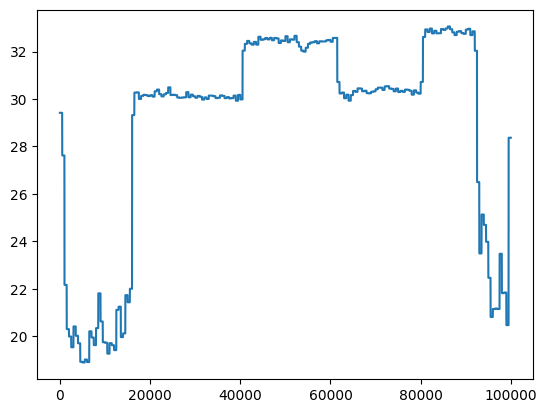

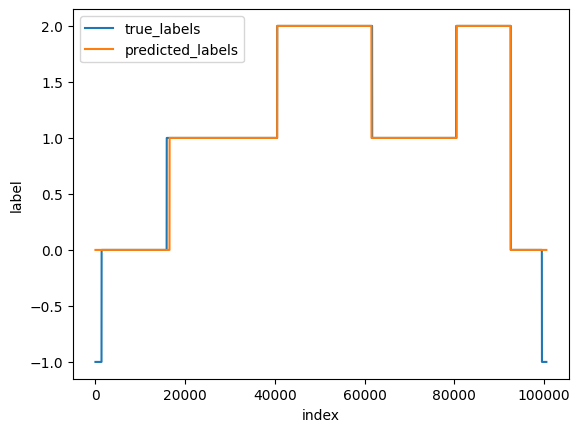

In [67]:
file = "mixed_data_labeled.txt"
file_path = os.path.join(current_path, "test_data", file)
data = pd.read_csv(file_path, header=None)
pandas_data = structure_file(data, test=True)
true_labels = np.array(pandas_data['label'])
predicted_labels = predict_fft_based(file_path, test_labels=True, window_size = 500, w_thres=29.8, r_thres=31.7, plot=True)

accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print(f"The accuracy for the chosen threshold is {accuracy:.3f}")

plt.figure()
plt.plot(pandas_data.index, true_labels, label='true_labels')
plt.plot(pandas_data.index, predicted_labels, label='predicted_labels')
plt.xlabel('index')
plt.ylabel('label')
plt.legend()
plt.show()

The accuracy for the chosen threshold is 0.960


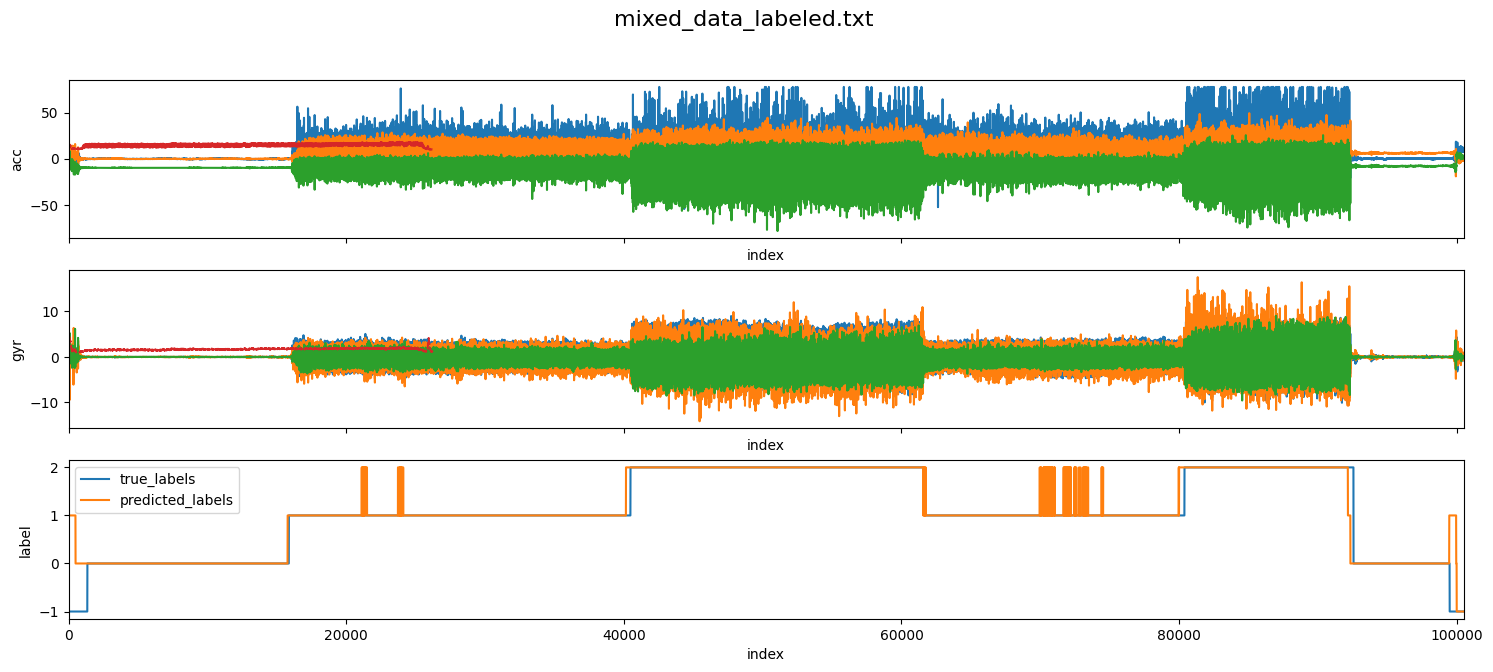

In [65]:
# Testing thresholding approach

file = "mixed_data_labeled.txt"
file_path = os.path.join(current_path, "test_data", file)

# Activity labels are integers (other=-1, standing_still=0, walking=1, running=2)
true_labels = np.array(pandas_data['label'])
predicted_labels = label_data(file_path)

accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print(f"The accuracy for the chosen threshold is {accuracy:.3f}")

# Plot data
fig, ax = plt.subplots(3, 1, sharex='col', figsize=(18, 7))
fig.suptitle(file, fontsize=16)
ax[0].plot(pandas_data.index, np.array(pandas_data['acc_z']), label='z')
ax[0].plot(pandas_data.index, np.array(pandas_data['acc_x']), label='x')
ax[0].plot(pandas_data.index, np.array(pandas_data['acc_y']), label='y')

ax[0].plot(rms_acc_ma, '--', label='rms_ma')
ax[0].set_xlabel('index')
ax[0].set_ylabel('acc')
ax[0].margins(x=0)
ax[1].plot(pandas_data.index, np.array(pandas_data['gyr_x']), label='x')
ax[1].plot(pandas_data.index, np.array(pandas_data['gyr_y']), label='y')
ax[1].plot(pandas_data.index, np.array(pandas_data['gyr_z']), label='z')
ax[1].plot(rms_gyr_ma, '--', label='rms_ma')
ax[1].set_xlabel('index')
ax[1].set_ylabel('gyr')
ax[1].margins(x=0)
ax[2].plot(pandas_data.index, true_labels, label='true_labels')
ax[2].plot(pandas_data.index, predicted_labels, label='predicted_labels')
ax[2].set_xlabel('index')
ax[2].set_ylabel('label')
ax[2].margins(x=0)
plt.legend()
plt.show()